In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from utils.network import *
from utils.create_data import *
from utils.data import Data

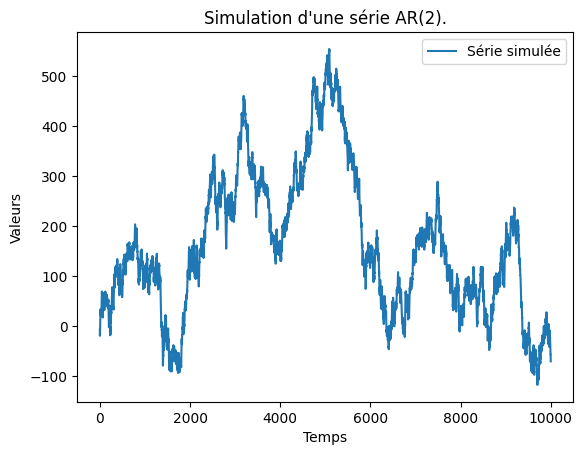

In [94]:
y = data_simulation(phi1=1.3, phi2=-0.3, sigma=4, n= 10000)
simple_plot(y)


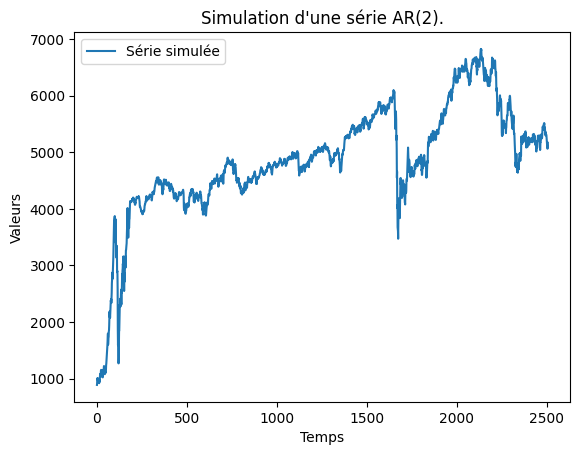

In [98]:
df = pd.read_csv('./data/GANData.csv')
simple_plot(df[df['ASSETNAME']=="Global Property USD Unhedged"]['PRICE'])

In [100]:
y = df[df['ASSETNAME']=="Global Property USD Unhedged"]['PRICE'].to_numpy()

In [101]:
y.shape

(2507,)

In [102]:
latent_dim = 10
ts_dim = 50
conditional = 10

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-4
lr_b = 1e-4
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = 1e-4, max_lr= 8e-4, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = 1e-4, max_lr= 6e-4, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 5000
batch_size = 128
use_cuda = torch.cuda.is_available()
scorepath = 'test'
print(use_cuda)

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda)
train.train_model(epochs=5000)

True


  0%|          | 0/5000 [00:00<?, ?it/s]

/home/onyxia/work/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1283: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 84%|████████▍ | 4199/5000 [44:52<08:16,  1.61it/s]  /tmp/ipykernel_6233/4034338551.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2,2,figsize=(10, 10))
100%|██████████| 5000/5000 [53:24<00:00,  1.56it/s]


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

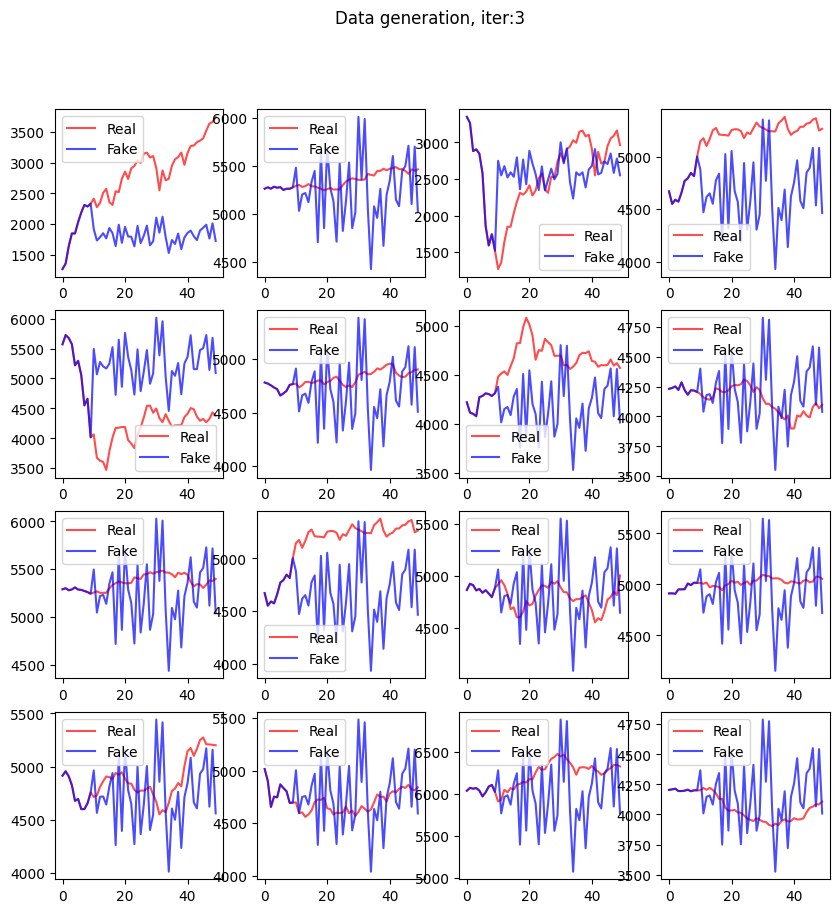

In [103]:
def show_examples(real, fake, size=2):
    real = np.squeeze(real)
    fake = np.squeeze(fake)

    fig, ax = plt.subplots(size,size,figsize=(10, 10))
    ax = ax.flatten()
    fig.suptitle('Data generation, iter:' +str(3))
    for i in range(ax.shape[0]):
        ax[i].plot(real[i], color='red', label='Real', alpha =0.7)
        ax[i].plot(fake[i], color='blue', label='Fake', alpha =0.7)
        ax[i].legend()

    plt.show()

show_examples(train.real_lines, train.fake_lines, size=4)

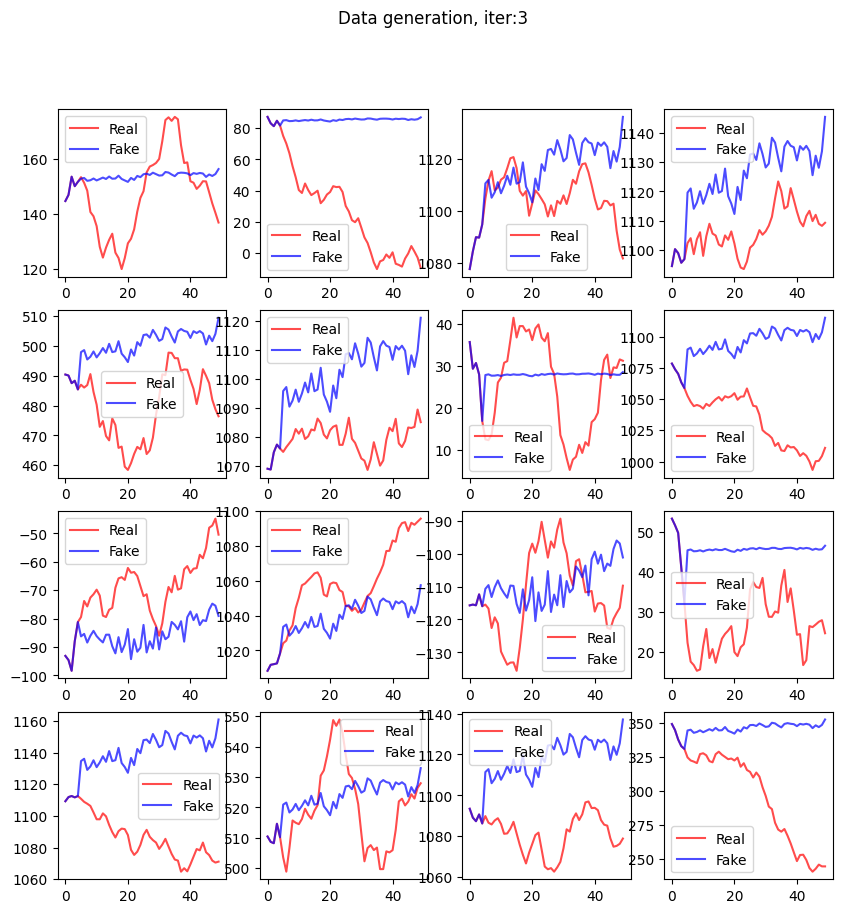

In [90]:
real = np.squeeze(train.real_lines)
fake = np.squeeze(train.fake_lines)

fig, ax = plt.subplots(4,4,figsize=(10, 10))
ax = ax.flatten()
fig.suptitle('Data generation, iter:' +str(3))
for i in range(ax.shape[0]):
    ax[i].plot(real[i], color='red', label='Real', alpha =0.7)
    ax[i].plot(fake[i], color='blue', label='Fake', alpha =0.7)
    ax[i].legend()

plt.show()